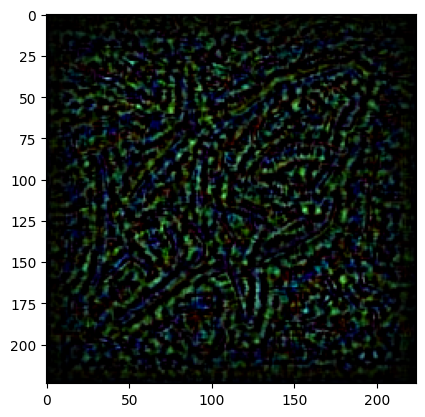

In [6]:
#Guided BackPropagation
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image

import cv2

#Loading a pretrained model like VGG16
model=keras.applications.VGG16(weights='imagenet')

class GuidedBackpropagation:
  def __init__(self,model):
    self.model=model
    self.gb_model=self.build_guided_model()

  def build_guided_model(self):
    gb_model=keras.models.Model(inputs=self.model.input,
                                outputs=self.model.get_layer('block5_conv3').output) #deep layer which is chosen for features

    for layer in gb_model.layers:
      if hasattr(layer,'activation'):
        layer.activation=tf.keras.activations.linear
    return gb_model

  def guided_backprop(self,img_array):
    img_array=tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
      tape.watch(img_array)
      outputs=self.gb_model(img_array)

    grads=tape.gradient(outputs,img_array)[0]
    return np.maximum(grads,0)

def preprocess_img(img_path):
  img=image.load_img(img_path,target_size=(224,224))
  img_array=image.img_to_array(img)
  img_array=np.expand_dims(img_array,axis=0)
  return keras.applications.vgg16.preprocess_input(img_array)

def visualize(img_path,guided_grads):
  img=cv2.imread(img_path)
  guided_grads=np.squeeze(guided_grads)
  guided_grads-=guided_grads.min()
  guided_grads/=guided_grads.max()

  plt.imshow(guided_grads)
  plt.show()

img_path='/content/shark.jpg'
img_array=preprocess_img(img_path)

gbp=GuidedBackpropagation(model)
guided_grads=gbp.guided_backprop(img_array)

visualize(img_path,guided_grads)


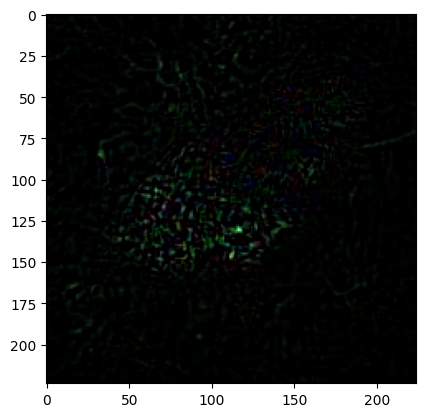

In [12]:
#LayerWise Relevance Propagation
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing import image

import cv2

model=VGG16(weights='imagenet')

class LRP:
  def __init__(self,model):
    self.model=model
    self.lrp_model=self.build_lrp_model()

  def build_lrp_model(self):
    lrp_model=Model(inputs=self.model.input,
                    outputs=self.model.get_layer('block5_conv3').output)
    return lrp_model

  def compute_lrp(self,img_array):
    img_array=tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
      tape.watch(img_array)
      outputs=self.lrp_model(img_array)

    relevance_scores=tape.gradient(outputs,img_array)[0]
    return np.maximum(relevance_scores,0)

def preprocess_image(img_path):
  img=image.load_img(img_path,target_size=(224,224))
  img_array=image.img_to_array(img)
  img_array=np.expand_dims(img_array,axis=0)
  return preprocess_input(img_array)

def visualize(img_path,relevance_scores):
  img=cv2.imread(img_path)
  relevance_scores=np.squeeze(relevance_scores)

  relevance_scores-=relevance_scores.min()
  relevance_scores/=relevance_scores.max()

  plt.imshow(relevance_scores,cmap='hot')
  plt.show()

img_path='/content/shark.jpg'
img_array=preprocess_image(img_path)

lrp=LRP(model)
relevance_scores=lrp.compute_lrp(img_array)

visualize(img_path,relevance_scores)


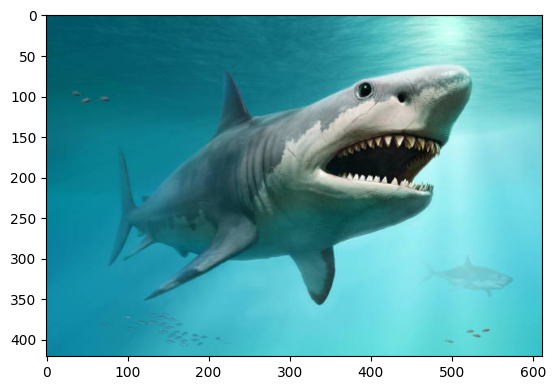

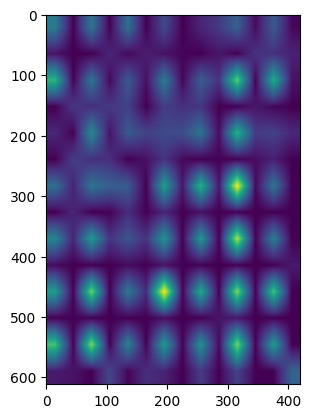

In [21]:
#GradCAM Visualization
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

def grad_cam(model,img_array,layer_name):
  grad_model=Model(inputs=model.input,
                   outputs=[model.get_layer(layer_name).output,model.output])

  img_array=tf.convert_to_tensor(img_array)

  with tf.GradientTape() as tape:
    conv_outputs,predictions=grad_model(img_array)

    class_index=tf.argmax(predictions[0])
    tape.watch(conv_outputs)
    loss=predictions[:,class_index]

  grads=tape.gradient(loss,conv_outputs)
  heatmap=tf.reduce_mean(grads,axis=-1)[0]
  return np.maximum(heatmap,0)

def display_heatmap(img_path,heatmap):
  img=cv2.imread(img_path)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  heatmap=cv2.resize(heatmap,(img.shape[0],img.shape[1]))

  plt.imshow(img)
  plt.show()
  plt.imshow(heatmap)
  plt.show()

def preprocess_image(img_path):
  img=image.load_img(img_path,target_size=(224,224))
  img_array=np.array(img)/255.0
  return np.expand_dims(img_array,axis=0)


model=VGG16(weights='imagenet')

img_path='/content/shark.jpg'
img_array=preprocess_image(img_path)

heatmap=grad_cam(model,img_array,'block5_conv3')
display_heatmap(img_path,heatmap)